In [2]:
# -*- coding: utf-8 -*-
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # pandas is a library for handling datasets
import os # to move around your operating system
import scipy as sp  # scientific computation library
import pylab

from mpl_toolkits.mplot3d import axes3d # in case we need to plot in 3D z=f(x,y)
import seaborn as sns  # another package for pretty graphs

# Scikit-learn (sklearn) is a powerful and fairly comprehensive library of ML algorithms
from sklearn import datasets
from sklearn.neighbors.kde import KernelDensity

In [3]:
#generate data
np.random.seed(10) 
# a seed ensures that re-running the random number generator yields the same outcome
# this is helpful for the purpose of sanity checking your implementations

Na = 100
class_a = []
m_a = np.array([4, 4]) #use when covariance matrices are the same

#use when covariance matrices are the same
s_a = np.array([[0.25, 0.21],
                [0.21, 0.25]])

#use when covariance matrices are different
#s_a = np.array([[0.34, 0.2],
#                [0.2, 0.4]]) 

for i in range(Na):
    x_a = np.random.multivariate_normal(m_a, s_a)
    class_a.append(x_a)

Nb = 80
class_b = []
m_b = np.array([6.5, 5])

s_b = np.array([[0.25, 0.21], 
                [0.21, 0.25]])

for i in range(Nb):
    x_b = np.random.multivariate_normal(m_b, s_b)
    class_b.append(x_b)

class_a = np.asarray(class_a)
class_b = np.asarray(class_b)
#print(class_a)

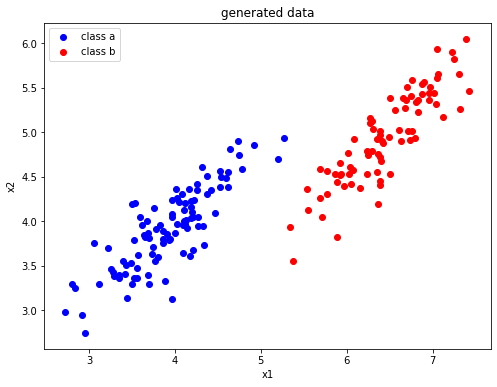

In [4]:
# plotting data
fig, ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
ax.set(xlabel="x1", ylabel="x2", title = "generated data")
ax.scatter(class_a[:,0] , class_a[:,1] , c='b', label='class a')
ax.scatter(class_b[:,0] , class_b[:,1] , c='r', label='class b')
ax.legend()

In [5]:
#1a
def proj_y(w, class_a, class_b):
    y_a = []
    y_b = []
    for i in range(len(class_a)):
        y_a.append(np.dot(w, class_a[i])) #projects each data point onto w

    for i in range(len(class_b)):
        y_b.append(np.dot(w, class_b[i]))
        
    return np.asarray(y_a), np.asarray(y_b)

In [6]:
# preparing to illustrate choices of different w directions
w_1 = [-2, 2]
w_2 = [0, 1]
w_3 = [2, 0]
w_4 = [3, 1]
guess_1 = proj_y(w_1, class_a, class_b)
guess_2 = proj_y(w_2, class_a, class_b)
guess_3 = proj_y(w_3, class_a, class_b)
guess_4 = proj_y(w_4, class_a, class_b)

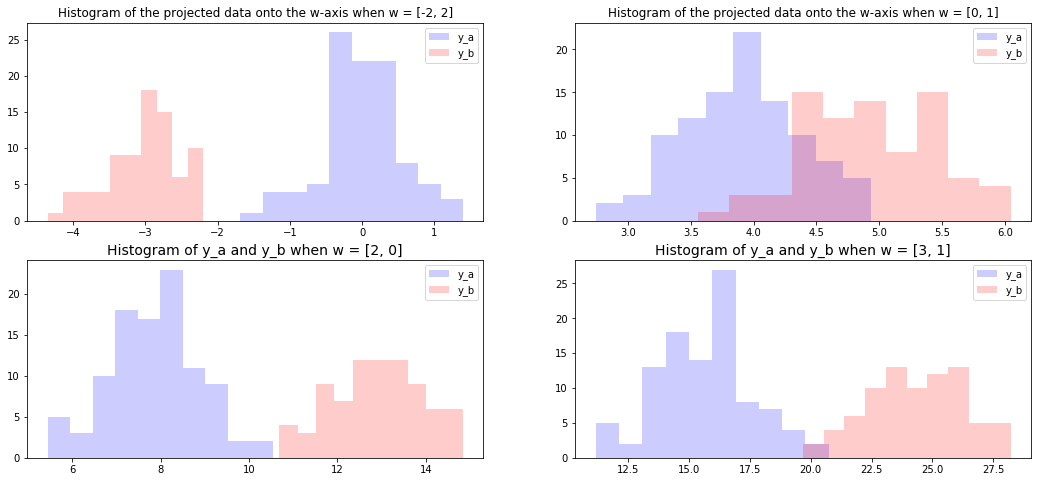

In [7]:
# plotting histograms for different directions of w

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))
ax[0][0].hist(guess_1[0], color='b',alpha=0.2, label="y_a")
ax[0][0].hist(guess_1[1], color='r', alpha=0.2, label='y_b')
ax[0][0].set_title("Histogram of the projected data onto the w-axis when w = %s" %w_1, fontsize = 12)
ax[0][0].legend()

ax[0][1].hist(guess_2[0], color='b',alpha=0.2, label="y_a")
ax[0][1].hist(guess_2[1], color='r', alpha=0.2, label='y_b')
ax[0][1].set_title("Histogram of the projected data onto the w-axis when w = %s" %w_2, fontsize = 12)
ax[0][1].legend()

ax[1][0].hist(guess_3[0], color='b',alpha=0.2, label="y_a")
ax[1][0].hist(guess_3[1], color='r', alpha=0.2, label='y_b')
ax[1][0].set_title("Histogram of y_a and y_b when w = %s" %w_3, fontsize = 14)
ax[1][0].legend()

ax[1][1].hist(guess_4[0], color='b',alpha=0.2, label="y_a")
ax[1][1].hist(guess_4[1], color='r', alpha=0.2, label='y_b')
ax[1][1].set_title("Histogram of y_a and y_b when w = %s" %w_4, fontsize = 14)
ax[1][1].legend()


In [8]:
# 1b
# calculate mean of a class
def mean(data):
    m = np.asarray([0, 0])
    for i in range(len(data)):
        m = m + np.asarray(data[i])
    
    return m /len(data)

In [9]:
# calculate S_B
def calc_SB(class_a, class_b):
    mean_a = np.asarray(mean(class_a))
    mean_b = np.asarray(mean(class_b))
    t1 = mean_b - mean_a #separation of means
    t1 = np.reshape(t1, (2, 1)) 
    t2 = np.transpose(t1) 
    S_B = np.matmul(t1, t2)
    return S_B

In [10]:
# calculate S_W
def calc_SW(class_a, class_b):
    mean_a = np.asarray(mean(class_a))
    mean_b = np.asarray(mean(class_b))

    term1 = np.asarray([[0, 0], [0, 0]])
    term2 = np.asarray([[0, 0], [0, 0]])
    
    for i in range(len(class_a)):
        t1 = class_a[i] - mean_a
        t1 = np.reshape(t1, (2, 1))
        t2 = np.transpose(t1)
        term1 = term1 + np.matmul(t1, t2)
        
    for i in range(len(class_b)):
        t1 = class_b[i] - mean_b
        t1 = np.reshape(t1, (2, 1))
        t2 = np.transpose(t1)
        term2 = term2 + np.matmul(t1, t2)
    
    S_W = term1 + term2
    return S_W

In [11]:
# Fisher criterion
def calc_Fish(w, class_a, class_b):
    F_num = np.matmul(w.T, np.matmul(calc_SB(class_a, class_b), w))
    F_den = np.matmul(w.T, np.matmul(calc_SW(class_a, class_b), w))
    F = F_num/F_den
    return F

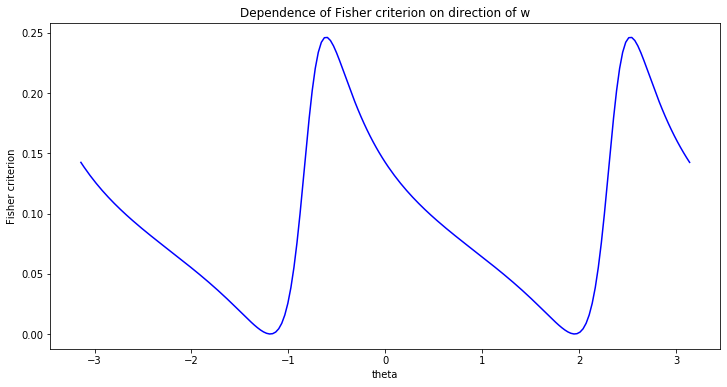

In [12]:
# plot dependence of F(w) on direction of w
w0 = np.asarray([1, 0])
w0 = np.reshape(w0, (2, 1))

theta_plot = [(np.pi*i)/100 for i in range(-100, 101)]
F_theta = []

for i in range(-100, 101):
    theta = (np.pi*i)/100
    R = [ [np.cos(theta), -np.sin(theta)], 
          [np.sin(theta), np.cos(theta)] ]

    w = np.matmul(R, w0)
    F_theta.append(calc_Fish(w, class_a, class_b))

F_theta = np.asarray(F_theta)
F_theta = np.reshape(F_theta, (len(range(-100, 101)), 1))

fig, ax = plt.subplots(figsize=(12,6),nrows=1, ncols=1)
ax.set(xlabel="theta", ylabel="Fisher criterion", title = "Dependence of Fisher criterion on direction of w")
ax.plot(theta_plot , F_theta , c='b')

In [13]:
# find w at max F

# first find theta at max F
F_theta = list(F_theta)
max_value = max(F_theta)
max_index = F_theta.index(max_value)
max_theta = theta_plot[max_index]

# now find w at max_theta
R = [ [np.cos(max_theta), -np.sin(max_theta)], 
      [np.sin(max_theta), np.cos(max_theta)] ]

w_best = np.matmul(R, w0)

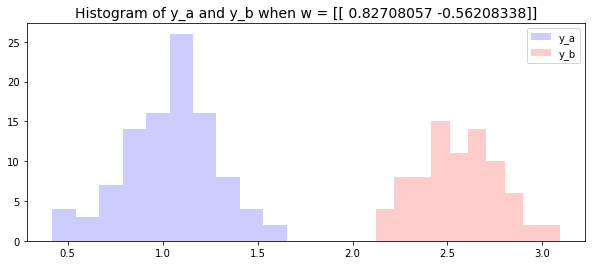

In [14]:
# plotting histogram of w_best
w_best = np.reshape(w_best, (1,2))
best = proj_y(w_best, class_a, class_b)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.hist(best[0], color='b',alpha=0.2, label="y_a")
ax.hist(best[1], color='r',alpha=0.2, label="y_b")
ax.set_title("Histogram of y_a and y_b when w = %s" %w_best, fontsize = 14)
ax.legend()


In [15]:
# 2a
def gaussian(x, mean, sigma):
    dev = np.asarray(x - mean)
    exp_arg = -0.5*np.dot(dev, np.matmul(np.linalg.inv(sigma), dev))
    num = np.exp(exp_arg)
    den = (2*np.pi)*(np.linalg.det(sigma)**0.5)
    #print(num)
    return num/den #returns the conditional prob that the point x is in the class with (mean, sigma)

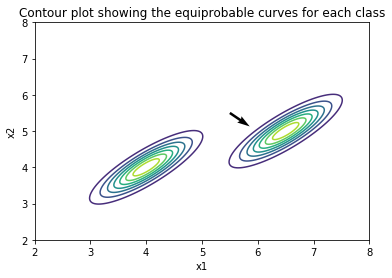

In [17]:
x1 = [i/100 for i in range(200, 801)]
x2 = [i/100 for i in range(200, 801)]
#print(type(x1))
#print(np.shape(x1))

P_a = np.ndarray((len(x1),len(x2)))
for j in range(601):
    for i in range(601):
        x = [x1[i], x2[j]]
        P_a[j][i] = gaussian(x, m_a, s_a)
        
P_b = np.ndarray((len(x1),len(x2)))
for j in range(601):
    for i in range(601):
        x = [x1[i], x2[j]]
        P_b[j][i] = gaussian(x, m_b, s_b)
        
#print(len(x2))

# Set the x (x1) axis and y (x2) axis limits
pylab.xlim([2,8])
pylab.ylim([2,8])
plt.title('Contour plot showing the equiprobable curves for each class') # Provide a title for the contour plot
plt.xlabel('x1') # Set x axis label for the contour plot
plt.ylabel('x2') # Set y axis label for the contour plot
contours_a = plt.contour(x1, x2, P_a)
contours_b = plt.contour(x1, x2, P_b) # Create contour lines or level curves using matplotlib.pyplot module
#plt.clabel(contours, inline=2, fontsize=10) # Display z values on contour lines
#plt.scatter(class_a[:,0] , class_a[:,1] , c='b', label='class a')
#plt.scatter(class_b[:,0] , class_b[:,1] , c='r', label='class b')



quiv = plt.quiver(5.5, 5.5, w_best[0][0], w_best[0][1], scale=3, scale_units='inches') 
plt.show() # Display the contour plot




In [331]:
# 2b
def log_odds(x, mean_a, mean_b, sigma_a, sigma_b, n_a, n_b):
    x = np.asarray(x)
    mean_a = np.asarray(mean_a)
    mean_b = np.asarray(mean_b)
    sigma_a = np.asarray(sigma_a)
    sigma_b = np.asarray(sigma_b)
    
    x = np.reshape(x, (2,1))
    mean_a = np.reshape(mean_a, (2,1))
    mean_b = np.reshape(mean_b, (2,1))

    t1_expa = -0.5*np.matmul(x.T ,np.matmul(np.linalg.inv(sigma_a), x))
    t2_expa = np.matmul(mean_a.T, np.matmul(np.linalg.inv(sigma_a), x))
    t3_expa = -0.5*np.matmul(mean_a.T, np.matmul(np.linalg.inv(sigma_a), mean_a))
    exp_a = t1_expa + t2_expa + t3_expa
    
    t1_expb = -0.5*np.matmul(x.T ,np.matmul(np.linalg.inv(sigma_b), x))
    t2_expb = np.matmul(mean_b.T, np.matmul(np.linalg.inv(sigma_b), x))
    t3_expb = -0.5*np.matmul(mean_b.T, np.matmul(np.linalg.inv(sigma_b), mean_b))
    exp_b = t1_expb + t2_expb + t3_expb
    
    g_a = - 0.5*np.log(np.linalg.det(sigma_a)) + np.log(n_a) + exp_a
    g_b = - 0.5*np.log(np.linalg.det(sigma_b)) + np.log(n_b) + exp_b
    
    #print(g_a, "\n")
    #print(g_b, "\n")
    #print(g_a-g_b, "\n")
    
    return (g_a-g_b), x

In [336]:
x1_out = []
x2_out = []

for i in range(601):
    for j in range(601):
        x = [x1[i], x2[j]]
        out = log_odds(x, m_a, m_b, s_a, s_b, Na, Nb)
        prob = out[0]
        co_ords = out[1]
        if((prob<10**(-1)) and (prob>-10**(-1))):
            x1_out.append(co_ords[0])
            x2_out.append(co_ords[1])
            


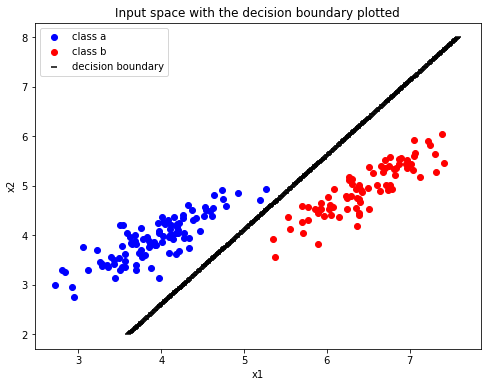

In [337]:
# plotting data
fig, ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
ax.set(xlabel="x1", ylabel="x2", title = "Input space with the decision boundary plotted")
ax.scatter(class_a[:,0] , class_a[:,1] , c='b', label='class a')
ax.scatter(class_b[:,0] , class_b[:,1] , c='r', label='class b')
ax.scatter(x1_out, x2_out, c='k', marker="_", linewidths=0.1, label='decision boundary')
ax.legend()